In [1]:
import sys
sys.path.append("..")
from common_utils import set_data_home
set_data_home("/mnt/d")
from common_utils import DATA_HOME, join
from lstm.sales_data import Sales_Dataset
from torch.utils.data.dataloader import DataLoader
import torch

In [2]:
SALE_HOME = join(DATA_HOME, "sales_data")
MODEL_PTH = join(join(DATA_HOME, "sale_model"), "sale_model.pth")

sd = Sales_Dataset(SALE_HOME)
test_set, train_set = torch.utils.data.random_split(sd, [0.2, 0.8])
train_dl = DataLoader(train_set, shuffle=True, batch_size=1)
test_dl = DataLoader(test_set, shuffle=True, batch_size=1)
len(train_dl), len(test_dl)

# print(sd.O.describe())
# print(sd.TR.describe())
# print(sd.TS.describe())
# print(sd.S.describe())
# print(sd[4][0].shape)
# print(sd[4][1].shape)
# print(sd[4][0], sd[4][1])

(43, 11)

In [3]:
from torch.nn import LSTM
from torch.nn import MSELoss
from torch import optim
import matplotlib.pyplot as plt

I, H = 71, 33
epochs = 100

model = LSTM(71, 33, batch_first=True).cuda()
loss = MSELoss()
# param yhat, y: 3d tensors
# def loss(yhat, y):
#     slen = yhat.shape[0] * yhat.shape[1] * yhat.shape[2]
#     return (((torch.log(yhat+1) - torch.log(y+1)) ** 2).sum() / slen) ** 0.5

adam = optim.Adam(model.parameters(), lr=0.001)
h, c = torch.randn(1,1, 33, dtype=torch.float32).cuda(), torch.randn(1,1, 33, dtype=torch.float32).cuda()
tr_losses, inf_losses = [], []

for _ in range(epochs):
    tr_l, inf_l = 0, 0
    for X, y in train_dl:
        yhat, (_, _) = model(X, (h, c))
        l = loss(yhat, y.cuda())

        adam.zero_grad()
        l.backward()
        adam.step()
        tr_l += l.item()

    for X, y in test_dl:
        yhat, (_, _) = model(X, (h, c))
        l = loss(yhat, y.cuda())
        inf_l += l.item()
        
    tr_losses.append(tr_l / len(train_dl))
    inf_losses.append(inf_l / len(test_dl))


### display losses

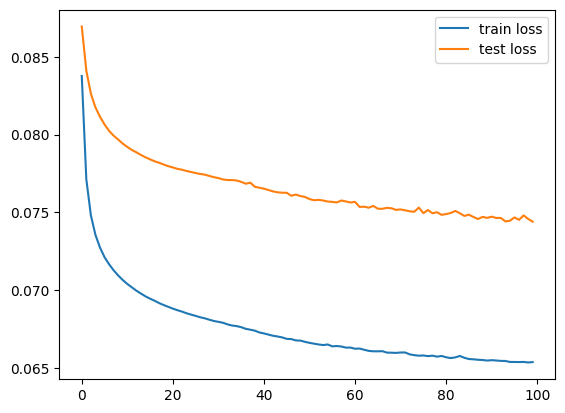

In [4]:
plt.plot(range(len(tr_losses)), tr_losses, label="train loss")
plt.plot(range(epochs), inf_losses, label="test loss")
plt.legend()
plt.show()


### save the model

In [5]:
torch.save(model.state_dict(), MODEL_PTH)
